# Gensim Model

<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gensim-Model" data-toc-modified-id="Gensim-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gensim Model</a></span><ul class="toc-item"><li><span><a href="#Daten-einlesen,-wählen-und-vorbereiten-" data-toc-modified-id="Daten-einlesen,-wählen-und-vorbereiten--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Daten einlesen, wählen und vorbereiten <a name="introduction"></a></a></span></li><li><span><a href="#Gensim-Modell-vorbereiten-" data-toc-modified-id="Gensim-Modell-vorbereiten--1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Gensim Modell vorbereiten <a name="paragraph0"></a></a></span></li><li><span><a href="#Topic-Modelling-aller-Daten-mit-raw-text-" data-toc-modified-id="Topic-Modelling-aller-Daten-mit-raw-text--1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Topic Modelling aller Daten mit raw text <a name="paragraph1"></a></a></span><ul class="toc-item"><li><span><a href="#Unigramm-" data-toc-modified-id="Unigramm--1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Unigramm <a name="subparagraph1"></a></a></span></li><li><span><a href="#Bigramm-" data-toc-modified-id="Bigramm--1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Bigramm <a name="subparagraph2"></a></a></span></li><li><span><a href="#Trigramm-" data-toc-modified-id="Trigramm--1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Trigramm <a name="subparagraph3"></a></a></span></li></ul></li><li><span><a href="#Topic-Modelling-aller-Daten-mit-POS" data-toc-modified-id="Topic-Modelling-aller-Daten-mit-POS-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Topic Modelling aller Daten mit POS</a></span><ul class="toc-item"><li><span><a href="#Unigramm" data-toc-modified-id="Unigramm-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Unigramm</a></span></li><li><span><a href="#Bigramm" data-toc-modified-id="Bigramm-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Bigramm</a></span></li><li><span><a href="#Trigramm" data-toc-modified-id="Trigramm-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Trigramm</a></span></li></ul></li><li><span><a href="#Ergebnisse-erkunden-" data-toc-modified-id="Ergebnisse-erkunden--1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Ergebnisse erkunden <a name="paragraph4"></a></a></span><ul class="toc-item"><li><span><a href="#Dominante-Topics-pro-Artikels" data-toc-modified-id="Dominante-Topics-pro-Artikels-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Dominante Topics pro Artikels</a></span></li><li><span><a href="#Repräsentativstes-Dokument-pro-Topic" data-toc-modified-id="Repräsentativstes-Dokument-pro-Topic-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Repräsentativstes Dokument pro Topic</a></span></li></ul></li></ul></li></ul></div>

In [1]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import Phrases

from gensim.models.phrases import Phraser
import pandas as pd

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Daten einlesen, wählen und vorbereiten <a name="introduction"></a>

In [2]:
df = pd.read_csv('../../Datensaetze/news_POS_POS_tags_nouns_adjectives_verb.csv')
df.head(1)

,category,filename,title,content,number_of_tokens,number_of_types,stemmed_text,POS_tags,POS,nouns,adjectives,verb
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,415.0,244.0,quarterli profit at US media giant timewarn j...,"['_SP', 'NNP', 'NNS', 'IN', 'NNP', 'NNS', 'NN'...",high fourth own fourth underlying exceptional ...,74.0,22.0,1.0


In [4]:
from collections import Counter

Counter(df.category)

Counter({'business': 510,
         'entertainment': 386,
         'politics': 417,
         'sport': 511,
         'tech': 401})

In [6]:
data1 = df[df['category'] == 'business']
data2 = df[df['category'] == 'entertainment']
data3 = df[df['category'] == 'tech']
data4 = df[df['category'] == 'politics']
data5 = df[df['category'] == 'sport']
genres = pd.concat([data1, data2, data3, data4, data5], axis=0)
#genres.head(1)
genres.shape

(2225, 12)

## Gensim Modell vorbereiten <a name="paragraph0"></a>

In [7]:
def create_docs(df, column):
    docs = []
    for i, row in df.iterrows():
        text = row[column].split()
        docs.append(text)
    return docs

In [8]:
def build_dictionary(docs):
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus

In [9]:
def build_model(docs, num_topics=8, chunksize=2000, passes=20, iterations=400, eval_every=None):
    dictionary, corpus = build_dictionary(docs)
    
    temp = dictionary[0] 
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    return model, dictionary, corpus

In [10]:
# top_topics = model.top_topics(corpus) #, num_words=20)

# # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print('Average topic coherence: %.4f.' % avg_topic_coherence)

# pprint(top_topics)

In [11]:
def visualise_LDA(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [12]:
def bi_trigramm(df, column):
    bigram_text= []
    for i, row in df.iterrows():
        text = row[column].split()
        bigram_text.append(text)

    bigram = Phrases(bigram_text, min_count=2, threshold=10) # höherer threshold für weniger phrases.
    trigram = Phrases(bigram[docs], threshold=10)  

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    return bigram_text, bigram_mod, trigram_mod

## Topic Modelling aller Daten mit raw text <a name="paragraph1"></a>

### Unigramm <a name="subparagraph1"></a>

In [13]:
docs = create_docs(df, 'content')
model, dictionary, corpus = build_model(docs)

In [14]:
print('Unique tokens: %d' % len(dictionary))
print('Documents: %d' % len(corpus))
pprint(model.print_topics())

Unique tokens: 3633
Documents: 2225
[(0,
  '0.024*"its" + 0.018*"US" + 0.008*"than" + 0.008*"-" + 0.007*"new" + '
  '0.006*"million" + 0.006*"about" + 0.006*"sales" + 0.006*"In" + '
  '0.006*"Apple"'),
 (1,
  '0.013*"could" + 0.010*"more" + 0.010*"-" + 0.009*"European" + 0.008*"than" '
  '+ 0.007*"up" + 0.007*"or" + 0.007*"report" + 0.006*"government" + '
  '0.006*"they"'),
 (2,
  '0.011*"more" + 0.011*"people" + 0.010*"they" + 0.010*"can" + 0.007*"music" '
  '+ 0.007*"technology" + 0.006*"its" + 0.006*"digital" + 0.006*"new" + '
  '0.006*"-"'),
 (3,
  '0.021*"best" + 0.016*"-" + 0.016*"film" + 0.013*"her" + 0.012*"who" + '
  '0.011*"won" + 0.010*"his" + 0.009*"first" + 0.008*"number" + 0.008*"last"'),
 (4,
  '0.032*"I" + 0.023*"you" + 0.012*"-" + 0.011*"my" + 0.010*"or" + '
  '0.009*"game" + 0.009*"can" + 0.009*"more" + 0.007*"about" + 0.007*"they"'),
 (5,
  '0.020*"mobile" + 0.012*"she" + 0.009*"Ms" + 0.008*"people" + 0.008*"more" + '
  '0.008*"one" + 0.007*"messages" + 0.007*"her" +

In [15]:
# visualise_LDA(model, dictionary, corpus)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.039253 -0.089225       1        1  39.822178
2     -0.079537 -0.017804       2        1  13.059409
4     -0.060555 -0.206515       3        1  12.312482
0      0.075815  0.165446       4        1  10.906147
1     -0.070401  0.090649       5        1   9.460114
3      0.314057 -0.026695       6        1   7.291485
6     -0.137591  0.024361       7        1   4.997702
5     -0.081041  0.059783       8        1   2.150484, topic_info=     Category         Freq     Term        Total  loglift  logprob
596   Default  1949.000000        I  1949.000000  30.0000  30.0000
1192  Default  1403.000000      you  1403.000000  29.0000  29.0000
763   Default   773.000000     best   773.000000  28.0000  28.0000
73    Default  2013.000000      its  2013.000000  27.0000  27.0000
787   Default  1697.000000   people  1697.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
485    Topic8    39.937798        A   963.042236   0.6567  -5.3363
113    Topic8    41.680740    said.  1428.669800   0.3050  -5.2936
466    Topic8    39.336048    other   970.094177   0.6342  -5.3515
660    Topic8    35.949509  million   570.113342   1.0758  -5.4415
141    Topic8    36.264236        -  3110.201904  -0.6121  -5.4328

[598 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1601      1  0.948525   "He
1601      2  0.010310   "He
1601      3  0.036085   "He
140       1  0.717342    "I
140       2  0.020334    "I
...     ...       ...   ...
1193      1  0.013862  your
1193      2  0.243972  your
1193      3  0.729143  your
1193      5  0.005545  your
1193      8  0.008317  your

[1584 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 5, 1, 2, 4, 7, 6])

In [16]:
pyLDAvis.save_html(vis, '../../Bilder/Topic Modeling/lda_text_alles.html')

### Bigramm <a name="subparagraph2"></a>

In [17]:
bigram_text, bigram_mod, trigram_mod = bi_trigramm(df, 'content')

bigramme = [bigram_mod[doc] for doc in bigram_text]

model, dictionary, corpus = build_model(bigramme)

In [18]:
pprint(model.print_topics())

[(0,
  '0.013*"people" + 0.012*"or" + 0.011*"their" + 0.009*"they" + 0.007*"were" + '
  '0.007*"use" + 0.007*"not" + 0.007*"more" + 0.006*"using" + '
  '0.006*"he_said."'),
 (1,
  '0.015*"software" + 0.013*"its" + 0.011*"or" + 0.010*"users" + 0.010*"Apple" '
  '+ 0.009*"their" + 0.009*"computer" + 0.009*"Microsoft" + 0.008*"will_be" + '
  '0.008*"people"'),
 (2,
  '0.013*"its" + 0.013*"games" + 0.010*"will_be" + 0.009*"new" + 0.009*"more" '
  '+ 0.009*"-" + 0.008*"game" + 0.007*"music" + 0.007*"Mr" + '
  '0.007*"technology"'),
 (3,
  '0.018*"his" + 0.016*"he" + 0.012*"I" + 0.011*"had" + 0.010*"her" + '
  '0.008*"-" + 0.008*"after" + 0.008*"she" + 0.007*"who" + 0.006*"their"'),
 (4,
  '0.016*"I" + 0.015*"-" + 0.014*"you" + 0.011*"not" + 0.011*"more" + '
  '0.009*"or" + 0.008*"this" + 0.008*"their" + 0.008*"an" + 0.007*"my"'),
 (5,
  '0.009*"people" + 0.009*"service" + 0.009*"-" + 0.008*"broadband" + '
  '0.007*"its" + 0.006*"services" + 0.006*"about" + 0.006*"will_be" + '
  '0.006*"like

In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.068710  0.121702       1        1  31.897057
3     -0.184744 -0.050083       2        1  20.948666
7     -0.142780  0.036763       3        1  12.773243
4      0.001788 -0.142860       4        1  10.177857
0      0.079526 -0.033019       5        1  10.024153
2      0.063228 -0.004981       6        1   5.386307
5      0.115823  0.114377       7        1   5.131750
1      0.135868 -0.041898       8        1   3.660959, topic_info=    Category         Freq    Term        Total  loglift  logprob
61   Default  1770.000000     its  1770.000000  30.0000  30.0000
490  Default  1272.000000       I  1272.000000  29.0000  29.0000
461  Default  2248.000000     his  2248.000000  28.0000  28.0000
665  Default  1142.000000  people  1142.000000  27.0000  27.0000
517  Default  2329.000000      he  2329.000000  26.0000  26.0000
..       ...          ...     ...          ...      ...      ...
117   Topic8    59.627907       -  2954.023682  -0.5954  -5.1753
190   Topic8    49.529564     out   851.040588   0.4636  -5.3608
6     Topic8    50.821716     But  1354.338867   0.0247  -5.3351
272   Topic8    45.694374     who  1364.653442  -0.0892  -5.4414
270   Topic8    44.895096    were  1530.238525  -0.2214  -5.4591

[591 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
401       1  0.098027       "I
401       2  0.729437       "I
401       3  0.031715       "I
401       4  0.138391       "I
2560      2  0.948404  "It_was
...     ...       ...      ...
1075      3  0.011907     your
1075      4  0.758049     your
1075      5  0.063502     your
1075      6  0.043657     your
1075      8  0.063502     your

[1633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 8, 5, 1, 3, 6, 2])

### Trigramm <a name="subparagraph3"></a>

In [20]:
trigramme = [trigram_mod[bigram_mod[doc]] for doc in bigram_text]

model, dictionary, corpus = build_model(trigramme)

In [21]:
pprint(model.print_topics())

[(0,
  '0.013*"had" + 0.012*"software" + 0.012*"virus" + 0.011*"Apple" + '
  '0.010*"this" + 0.009*"its" + 0.009*"his" + 0.008*"Mr" + 0.008*"about" + '
  '0.007*"used"'),
 (1,
  '0.013*"-" + 0.010*"its" + 0.007*"are" + 0.006*"were" + 0.006*"had" + '
  '0.006*"their" + 0.006*"not" + 0.005*"his" + 0.005*"will" + '
  '0.005*"government"'),
 (2,
  '0.010*"-" + 0.010*"are" + 0.009*"its" + 0.008*"more" + 0.008*"technology" + '
  '0.008*"will" + 0.008*"or" + 0.008*"will_be" + 0.006*"new" + 0.006*"music"'),
 (3,
  '0.012*"are" + 0.011*"or" + 0.010*"their" + 0.009*"people" + 0.009*"were" + '
  '0.008*"users" + 0.006*"use" + 0.006*"site" + 0.006*"search" + '
  '0.006*"sites"'),
 (4,
  '0.015*"are" + 0.009*"its" + 0.008*"people" + 0.008*"they" + '
  '0.007*"technology" + 0.007*"Apple" + 0.006*"consumers" + 0.006*"music" + '
  '0.006*"their" + 0.006*"were"'),
 (5,
  '0.022*"his" + 0.012*"he" + 0.010*"-" + 0.010*"who" + 0.009*"after" + '
  '0.009*"had" + 0.007*"her" + 0.006*"their" + 0.006*"also" +

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.085584 -0.025344       1        1  35.720573
5     -0.233221 -0.107463       2        1  22.631929
6     -0.020689 -0.018643       3        1  15.463874
2      0.062236 -0.045341       4        1   8.366093
3      0.056483  0.044319       5        1   6.131480
7      0.164129 -0.068000       6        1   5.982866
4      0.112510 -0.022697       7        1   3.410080
0     -0.055864  0.243169       8        1   2.293098, topic_info=    Category         Freq       Term        Total  loglift  logprob
656  Default  2101.000000        his  2101.000000  30.0000  30.0000
228  Default  2206.000000        are  2206.000000  29.0000  29.0000
60   Default  1676.000000        its  1676.000000  28.0000  28.0000
51   Default  1558.000000        had  1558.000000  27.0000  27.0000
666  Default  1160.000000     people  1160.000000  26.0000  26.0000
..       ...          ...        ...          ...      ...      ...
75    Topic8    31.838091     one_of   473.572632   1.0756  -5.3122
386   Topic8    33.201313      other   737.530762   0.6745  -5.2703
655   Topic8    31.021774  have_been   489.961243   1.0156  -5.3382
114   Topic8    33.609440       will  1447.702393   0.0123  -5.2581
6     Topic8    31.447535        But  1211.033936   0.1244  -5.3245

[590 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
117       1  0.444587         -
117       2  0.218868         -
117       3  0.176054         -
117       4  0.083232         -
117       5  0.010275         -
...     ...       ...       ...
3224      3  0.942311  you_have
1079      3  0.817847      your
1079      4  0.132413      your
1079      5  0.035051      your
1079      7  0.011684      your

[1593 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 3, 4, 8, 5, 1])

## Topic Modelling aller Daten mit POS

### Unigramm

In [23]:
docs = create_docs(df, 'POS')
model, dictionary, corpus = build_model(docs)

In [24]:
pprint(model.print_topics())

[(0,
  '0.024*"search" + 0.023*"information" + 0.019*"site" + 0.019*"-" + '
  '0.018*"mail" + 0.018*"net" + 0.017*"web" + 0.015*"e" + 0.012*"way" + '
  '0.012*"website"'),
 (1,
  '0.056*"music" + 0.048*"%" + 0.029*"year" + 0.029*"digital" + 0.017*"report" '
  '+ 0.016*"show" + 0.016*"mobile" + 0.014*"market" + 0.014*"industry" + '
  '0.013*"new"'),
 (2,
  '0.024*"government" + 0.014*"legal" + 0.013*"election" + 0.011*"public" + '
  '0.011*"law" + 0.011*"-" + 0.010*"party" + 0.010*"new" + 0.010*"action" + '
  '0.009*"case"'),
 (3,
  '0.024*"TV" + 0.023*"technology" + 0.019*"mobile" + 0.018*"new" + '
  '0.013*"high" + 0.013*"computer" + 0.013*"video" + 0.011*"market" + '
  '0.011*"phone" + 0.011*"DVD"'),
 (4,
  '0.021*"software" + 0.018*"net" + 0.017*"-" + 0.016*"broadband" + '
  '0.016*"service" + 0.015*"technology" + 0.014*"phone" + 0.014*"security" + '
  '0.013*"virus" + 0.013*"other"'),
 (5,
  '0.047*"%" + 0.022*"year" + 0.018*"company" + 0.017*"market" + 0.016*"firm" '
  '+ 0.014*"e

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.128888  0.127811       1        1  27.666069
2      0.066952  0.116603       2        1  22.789028
5     -0.197682  0.189826       3        1  14.385663
3     -0.021854 -0.100691       4        1   8.260233
4     -0.036858 -0.127439       5        1   8.057869
1     -0.187437 -0.087432       6        1   6.832892
6      0.158908  0.007613       7        1   6.323130
0      0.089084 -0.126289       8        1   5.685120, topic_info=     Category         Freq        Term        Total  loglift  logprob
1093  Default   990.000000        game   990.000000  30.0000  30.0000
0     Default  1740.000000           %  1740.000000  29.0000  29.0000
34    Default   868.000000       music   868.000000  28.0000  28.0000
674   Default   481.000000     digital   481.000000  27.0000  27.0000
373   Default   662.000000  technology   662.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
188    Topic8    77.377419       other  1036.689941   0.2722  -4.7197
38     Topic8    55.912041        part   593.221436   0.5055  -5.0446
68     Topic8    54.695721          do   782.193054   0.2070  -5.0666
37     Topic8    50.124344         own   426.304871   0.7267  -5.1539
273    Topic8    49.151989      public   530.396362   0.4886  -5.1735

[520 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.000575     %
0         2  0.000575     %
0         3  0.594207     %
0         4  0.021263     %
0         5  0.082178     %
...     ...       ...   ...
56        6  0.173545  year
56        7  0.041537  year
56        8  0.004552  year
211       4  0.269357   yen
211       6  0.673394   yen

[1386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 6, 4, 5, 2, 7, 1])

### Bigramm

In [26]:
bigram_text, bigram_mod, trigram_mod = bi_trigramm(df, 'POS')

bigramme = [bigram_mod[doc] for doc in bigram_text]

model, dictionary, corpus = build_model(bigramme)

In [27]:
pprint(model.print_topics())

[(0,
  '0.023*"first" + 0.019*"time" + 0.016*"game" + 0.016*"last" + 0.014*"old" + '
  '0.013*"team" + 0.012*"second" + 0.011*"year" + 0.011*"club" + 0.010*"side"'),
 (1,
  '0.029*"government" + 0.014*"public" + 0.012*"new" + 0.011*"election" + '
  '0.009*"law" + 0.009*"party" + 0.009*"legal" + 0.008*"case" + 0.008*"part" + '
  '0.008*"other"'),
 (2,
  '0.023*"computer" + 0.019*"world" + 0.019*"problem" + 0.018*"project" + '
  '0.013*"other" + 0.013*"access" + 0.010*"camera" + 0.010*"public" + '
  '0.010*"news" + 0.010*"many"'),
 (3,
  '0.050*"game" + 0.025*"time" + 0.019*"film" + 0.017*"first" + 0.015*"gaming" '
  '+ 0.014*"year" + 0.013*"top" + 0.013*"new" + 0.011*"world" + 0.010*"list"'),
 (4,
  '0.027*"technology" + 0.026*"new" + 0.019*"year" + 0.018*"high" + '
  '0.017*"digital" + 0.016*"TV" + 0.014*"%" + 0.014*"broadband" + 0.013*"next" '
  '+ 0.013*"industry"'),
 (5,
  '0.073*"%" + 0.036*"year" + 0.014*"last" + 0.014*"firm" + 0.014*"company" + '
  '0.012*"market" + 0.012*"report

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.008128  0.105342       1        1  24.660574
5      0.063259 -0.171564       2        1  18.101545
0     -0.228666 -0.012646       3        1  17.640682
3     -0.171118 -0.019259       4        1  12.883499
7      0.097063 -0.049666       5        1   8.601956
4      0.047631 -0.100964       6        1   7.770602
2      0.040759  0.206438       7        1   5.388079
6      0.159201  0.042321       8        1   4.953060, topic_info=     Category         Freq        Term        Total  loglift  logprob
0     Default  1888.000000           %  1888.000000  30.0000  30.0000
1037  Default  1199.000000        game  1199.000000  29.0000  29.0000
69    Default  1004.000000  government  1004.000000  28.0000  28.0000
335   Default   579.000000  technology   579.000000  27.0000  27.0000
200   Default   359.000000         net   359.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
0      Topic8    62.191746           %  1888.306274  -0.4080  -4.6167
97     Topic8    58.063606        time  1375.395386  -0.1598  -4.6853
48     Topic8    50.358719         way   727.873352   0.3342  -4.8277
203    Topic8    47.779148      number   634.143250   0.4195  -4.8803
49     Topic8    48.839481        year  1724.485229  -0.5590  -4.8583

[520 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.001589     %
0         2  0.885450     %
0         5  0.002648     %
0         6  0.073611     %
0         7  0.003707     %
...     ...       ...   ...
49        5  0.012178  year
49        6  0.106119  year
49        7  0.009858  year
49        8  0.028414  year
186       2  0.976835   yen

[1389 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 1, 4, 8, 5, 3, 7])

### Trigramm

In [29]:
trigramme = [trigram_mod[bigram_mod[doc]] for doc in bigram_text]

model, dictionary, corpus = build_model(trigramme)

In [30]:
pprint(model.print_topics())

[(0,
  '0.030*"first" + 0.023*"time" + 0.019*"game" + 0.016*"second" + 0.015*"team" '
  '+ 0.013*"match" + 0.013*"last" + 0.013*"side" + 0.011*"great" + '
  '0.011*"final"'),
 (1,
  '0.025*"government" + 0.016*"public" + 0.014*"legal" + 0.012*"action" + '
  '0.012*"company" + 0.010*"party" + 0.010*"law" + 0.009*"election" + '
  '0.009*"new" + 0.009*"case"'),
 (2,
  '0.077*"game" + 0.031*"time" + 0.027*"gaming" + 0.016*"first" + 0.014*"new" '
  '+ 0.014*"player" + 0.012*"play" + 0.012*"console" + 0.011*"real" + '
  '0.011*"world"'),
 (3,
  '0.023*"%" + 0.021*"new" + 0.020*"software" + 0.017*"technology" + '
  '0.015*"computer" + 0.013*"other" + 0.013*"firm" + 0.013*"information" + '
  '0.012*"such" + 0.011*"are_are"'),
 (4,
  '0.040*"mobile" + 0.036*"phone" + 0.025*"broadband" + 0.022*"service" + '
  '0.018*"%" + 0.015*"are_are" + 0.015*"technology" + 0.013*"year" + '
  '0.013*"TV" + 0.012*"such"'),
 (5,
  '0.031*"year" + 0.027*"%" + 0.015*"last" + 0.012*"new" + 0.011*"film" + '
  '0.00

In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.045541  0.092759       1        1  33.969578
1     -0.025100  0.196969       2        1  19.877186
0      0.261934  0.016873       3        1  12.082874
3     -0.114270 -0.016068       4        1   8.656729
7     -0.062079  0.036517       5        1   8.125497
6     -0.111651 -0.145265       6        1   6.285358
4     -0.140243 -0.024566       7        1   5.952550
2      0.145869 -0.157218       8        1   5.050230, topic_info=     Category         Freq        Term        Total  loglift  logprob
1040  Default   788.000000        game   788.000000  30.0000  30.0000
0     Default  1548.000000           %  1548.000000  29.0000  29.0000
30    Default   520.000000       music   520.000000  28.0000  28.0000
377   Default   366.000000      mobile   366.000000  27.0000  27.0000
336   Default   612.000000  technology   612.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
256    Topic8    50.487034        week   610.354614   0.4934  -4.8505
62     Topic8    48.014530          do   445.941681   0.7571  -4.9007
799    Topic8    45.140644         day   317.887024   1.0338  -4.9624
49     Topic8    52.799503        year  1855.879395  -0.5739  -4.8057
94     Topic8    43.944744        such   708.026550   0.2062  -4.9892

[518 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.743533     %
0         2  0.000646     %
0         4  0.164727     %
0         6  0.001292     %
0         7  0.089792     %
...     ...       ...   ...
49        4  0.053344  year
49        5  0.030713  year
49        6  0.054422  year
49        7  0.054422  year
49        8  0.028558  year

[1370 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 4, 8, 7, 5, 3])

## Ergebnisse erkunden <a name="paragraph4"></a>

### Dominante Topics pro Artikels

In [50]:
def dominant_topics(ldamodel, corpus, texts, genre, artist):
    sent_topics_df = pd.DataFrame()


    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)


        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']


    contents = pd.Series(texts)
    genres = pd.Series(genre)
    artist = pd.Series(artist)
    sent_topics_df = pd.concat([sent_topics_df, contents, genres, artist], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = dominant_topics(
   ldamodel=model, corpus=corpus, texts=df.POS.values, genre=df.category.values, artist=df.filename.values
)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
   'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Genre', 'Filename'
]


df_dominant_topic.head(15)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Genre,Filename
0,0,5.0,0.7044,"year, %, last, new, film, first, week, time, e...",high fourth own fourth underlying exceptional ...,business,001.txt
1,1,5.0,0.8654,"year, %, last, new, film, first, week, time, e...",late recent sanguine current current next shar...,business,002.txt
2,2,5.0,0.4932,"year, %, last, new, film, first, week, time, e...",Russian former similar foreign Legal such real...,business,003.txt
3,3,5.0,0.8918,"year, %, last, new, film, first, week, time, e...",high pre - tax chief respectable third full la...,business,004.txt
4,4,5.0,0.8557,"year, %, last, new, film, first, week, time, e...",French last major global top other Last LVMH b...,business,005.txt
5,5,5.0,0.7707,"year, %, last, new, film, first, week, time, e...",technical similar sized previous annual annual...,business,006.txt
6,6,5.0,0.8991,"year, %, last, new, film, first, week, time, e...",non - farm new enough fine net first net last ...,business,007.txt
7,7,5.0,0.6682,"year, %, last, new, film, first, week, time, e...",unlikely restrictive hard global economic flex...,business,008.txt
8,8,5.0,0.8936,"year, %, last, new, film, first, week, time, e...",past joint Good blended supplementary pregnant...,business,009.txt
9,9,1.0,0.5892,"government, public, legal, action, company, pa...",federal anti - racketeering nicotine multi - p...,business,010.txt


In [51]:
from collections import Counter
import numpy as np
df1 = df_dominant_topic.groupby(['Dominant_Topic', 'Genre'])['Topic_Perc_Contrib'].apply(list)
topics = df1.to_frame()
for i, row in topics.iterrows():
    row.Topic_Perc_Contrib = len(row.Topic_Perc_Contrib)
topics

Topic_Perc_Contrib
Dominant_Topic Genre                           
0.0            politics                       2
               sport                        337
               tech                           5
1.0            business                      65
               entertainment                 32
               politics                     323
               sport                         33
               tech                          42
2.0            business                       1
               entertainment                  6
               politics                       1
               sport                          2
               tech                          30
3.0            business                       9
               entertainment                  4
               politics                       3
               sport                          2
               tech                         130
4.0            business                       6
               entertainment                  3
               politics                       1
               tech                          67
5.0            business                     423
               entertainment                288
               politics                      75
               sport                        136
               tech                           6
6.0            business                       1
               entertainment                 43
               tech                          50
7.0            business                       5
               entertainment                 10
               politics                      12
               sport                          1
               tech                          71

In [52]:
topics = topics.reset_index()

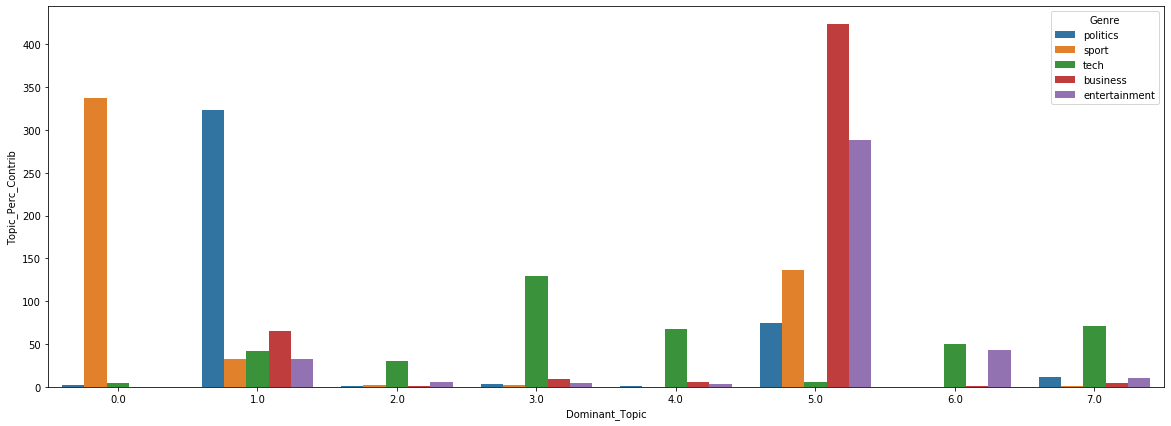

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,7))
sns.barplot(x=topics.Dominant_Topic, y="Topic_Perc_Contrib", hue='Genre',data=topics)
plt.savefig('../../Bilder/Topic Modeling/topic_modelling_verteilung')
plt.show()

In [54]:
for i, v in Counter(df_dominant_topic[df_dominant_topic.Genre=='sport'].Dominant_Topic).items():
    print(f"Topic {i} tritt {v} mal auf")

Topic 0.0 tritt 337 mal auf
Topic 1.0 tritt 33 mal auf
Topic 5.0 tritt 136 mal auf
Topic 7.0 tritt 1 mal auf
Topic 2.0 tritt 2 mal auf
Topic 3.0 tritt 2 mal auf


### Repräsentativstes Dokument pro Topic

In [55]:
import numpy as np
representative = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    representative = pd.concat([representative, grp.sort_values(['Perc_Contribution']).head(1)], axis=0)
representative.reset_index(drop=True, inplace=True)

representative.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text", "Genre", "Artist"
]
representative

,Topic_Number,Contribution_Perc,Keywords,Text,Genre,Artist
0,0.0,0.2972,"first, time, game, second, team, match, last, ...",wild Precious last Parliamentary married other...,politics,113.txt
1,1.0,0.2874,"government, public, legal, action, company, pa...",sure nuclear top key nuclear major nuclear sen...,politics,052.txt
2,2.0,0.2805,"game, time, gaming, first, new, player, play, ...",recent able grand same last hard instant basic...,tech,135.txt
3,3.0,0.2765,"%, new, software, technology, computer, other,...",iconic 10th remarkable popular dictionary rude...,tech,065.txt
4,4.0,0.3196,"mobile, phone, broadband, service, %, are_are,...",vile filthy wonderful concerned worried such b...,entertainment,281.txt
5,5.0,0.2639,"year, %, last, new, film, first, week, time, e...",controversial new only sensitive sensitive per...,entertainment,166.txt
6,6.0,0.2830,"music, TV, technology, are_are, content, digit...",countless past good much important gregarious ...,entertainment,181.txt
7,7.0,0.2523,"net, other, new, are_are, world, computer, way...",top dictionary last popular Other major such p...,tech,151.txt


In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cv = CountVectorizer(max_features=2000, min_df=1, max_df=300, stop_words='english')
cv.fit(representative['Keywords'])

results = cv.transform(representative['Keywords'])

features = cv.get_feature_names()

In [57]:
df_res = pd.DataFrame(results.toarray(), columns=features)
# df_res = df_res.set_index(df.genre1)
df_res

,action,are_are,broadband,case,company,computer,console,content,digital,economy,...,team,technology,time,tv,video,way,week,work,world,year
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
6,0,1,0,0,0,0,0,1,1,0,...,0,1,0,1,1,0,0,0,0,0
7,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0


In [58]:
df_res.loc['sum']=df_res.sum()
df_res = df_res.div(df_res.sum(axis=1), axis=0)
df_res.sort_values(by=['sum'], axis=1, inplace=True, ascending=False)
df_res

,new,are_are,technology,time,tv,game,year,computer,world,video,...,match,firm,gaming,government,great,high,information,law,legal,mobile
0,0.000000,0.000000,0.000000,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000
2,0.111111,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.111111,0.000000,...,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.142857,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,...,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
4,0.000000,0.125000,0.125000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000
5,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.111111,0.111111,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
7,0.125000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sum,0.092308,0.061538,0.061538,0.046154,0.030769,0.030769,0.030769,0.030769,0.030769,0.015385,...,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385


In [59]:
genre = df_res[df_res.index==0]
genre.loc['sum']=genre.sum()
genre = genre.div(genre.sum(axis=1), axis=0)
genre.sort_values(by=['sum'], axis=1, inplace=True, ascending=False)
genre

,match,time,team,game,great,second,final,economy,broadband,case,...,software,play,player,real,way,work,service,net,are_are,mobile
0,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


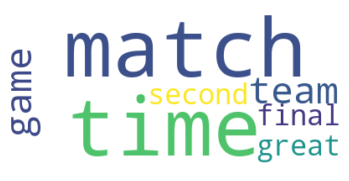

In [60]:
from wordcloud import WordCloud

def makeImage(text, figname):
    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(figname)
    plt.show()

text = genre.loc['sum']
# text = abba.any()
makeImage(text, "../../Bilder/Topic Modeling/wordcloud_Topic0")